In [1]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

sns.set_theme(style='white')
from scipy.stats import spearmanr, ttest_ind, mannwhitneyu
import gseapy as gp

from scripts.utils import get_treatment_info, load_from_pickle

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")


treatment_mapping_dict_simple = {
'bph':'BPH',
'untreated':'TRNA',
'goserelin':'NEADT',
'bicalutamide':'NEADT',
'degarelix':'NEADT',
'degarelix_apalutamide':'NEADT',
'crpc':'CRPC'}

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zu2p67ji because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
pseudobulk_dat = pd.read_csv('data/spatial_pseudobulk_unnormalized.csv',index_col=0)
treat_info = get_treatment_info()

# Since the data has come through different pipelines, some genes might be present in only Tampere or only ARNEO
# Drop the genes that have 0 counts in either cohort
tampere_samples = pseudobulk_dat.columns[:37].tolist()
arneo_samples = pseudobulk_dat.columns[37:].tolist()
pseudobulk_dat = pseudobulk_dat[(pseudobulk_dat[tampere_samples].sum(axis=1) != 0) & (pseudobulk_dat[arneo_samples].sum(axis=1) != 0)]


## Plotting the expression of individual genes

### TPM normalization

In [3]:
def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths

# Specify the path to your GTF file
gtf_file_path = './gencode.v43.annotation.gtf'

# Extract gene lengths from the GTF file
gene_lengths = extract_gene_lengths_from_gtf(gtf_file_path)


In [4]:
# Subset the pseudobulk data to only contain those genes that have annotation
pseudobulk_dat = pseudobulk_dat[pseudobulk_dat.index.isin(gene_lengths.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = pseudobulk_dat.index.map(gene_lengths).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

In [5]:
# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb=gene_length_mapping):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df

# Perform TPM normalization
tpm_normalized_dat = calculate_tpm(pseudobulk_dat)

# Modify the counts and subet categories

categories =['untreated','goserelin','bicalutamide', 'degarelix','degarelix_apalutamide']

# Add pseudocount and log2-transform
log2_tpm_normalized_dat = np.log2(tpm_normalized_dat.T +1 )

# Map treatment and filter according TRNA-NEADT
log2_tpm_normalized_dat['treatment'] = log2_tpm_normalized_dat.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()
log2_tpm_normalized_dat['treatment_detailed'] = log2_tpm_normalized_dat.index.map(treat_info)




### Reading TRNA vs NEADT DESeq2 results from a file

In [6]:
# Run this just to get the results
de_res = pd.read_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv',index_col=0)
de_res = de_res.sort_values('log2FoldChange')
de_res_signif = de_res[(np.abs(de_res['log2FoldChange']) >=1) & (de_res['padj'] < 0.05)].sort_values('log2FoldChange') 
de_res_signif

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ORM2,205.163010,-5.892494,1.221084,-4.825625,0.000001,0.000030
PCGEM1,282.375000,-4.911999,1.130320,-4.345672,0.000014,0.000199
FGL1,18.941490,-4.875488,1.253155,-3.890570,0.000100,0.000969
ORM1,63.875935,-4.637892,1.575119,-2.944471,0.003235,0.014901
LLCFC1,1.912150,-4.634777,1.337713,-3.464703,0.000531,0.003549
...,...,...,...,...,...,...
CCN1,1389.128500,19.841198,6.789952,2.922141,0.003476,0.015720
CCN2,2127.088900,20.177806,6.508118,3.100406,0.001933,0.010008
IGLC1,2901.869000,20.290042,5.781115,3.509711,0.000449,0.003112
TLE5,3082.846000,20.573904,6.095636,3.375186,0.000738,0.004648


### Looking for meaningful genes

In [54]:
# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

# Fix some of the encoding
gene_set_df = gene_set_df.replace({'NKX3–1':'NKX3-1','C1ORF116':'C1orf116'})


def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

In [9]:
deseq2_results_df = de_res_signif.copy()

marker_genes = check_top_markers('Club epithelium')['gene'].tolist()
#marker_genes = check_top_markers('Club epithelium')['gene'].tolist()
#gene_set = np.intersect1d(gene_set_df['MP19 Epithelial Senescence'].copy().tolist(),gene_set_df['Club'].copy().tolist())
#gene_set = gene_set_df['MP19 Epithelial Senescence'].copy().tolist()
#gene_set = gene_set_df['Luminal progenitor'].copy().tolist()
gene_set = gene_set_df['MP19 Epithelial Senescence'].copy().tolist()

# Genes that overlap between two signatures (e.g. EpiSen signatures and Club region markers) AND are DE-genes between TRNA and NEADT, 
gene_set = np.intersect1d(marker_genes,gene_set)
#gene_set = marker_genes.copy()


for g in deseq2_results_df.index.tolist():
    if g in gene_set:
        print(deseq2_results_df.loc[g,['baseMean','log2FoldChange','padj']])
        print('')
    #    print(g)

baseMean          1362.059300
log2FoldChange       1.224156
padj                 0.033418
Name: KRT7, dtype: float64

baseMean          2206.22300
log2FoldChange       1.29904
padj                 0.00006
Name: IGFBP3, dtype: float64

baseMean          535.675100
log2FoldChange      1.499834
padj                0.000161
Name: CRABP2, dtype: float64

baseMean          1145.236700
log2FoldChange       2.018718
padj                 0.000018
Name: SLPI, dtype: float64

baseMean          533.733950
log2FoldChange      2.508518
padj                0.027750
Name: KRT13, dtype: float64



### Plotting violinplot & heatmap (Figures 5e & 5f) 

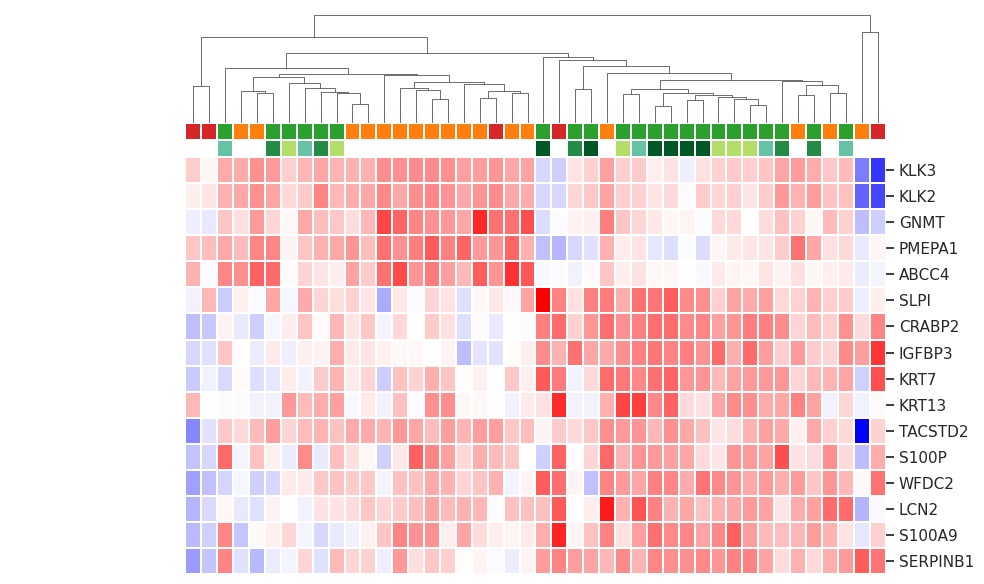

In [169]:
# Heatmap

# Leave out the NLR-associated genes from the heatmap
genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4',#'NKX3-1', # AR
    'SLPI','CRABP2','IGFBP3','KRT7','KRT13',# EpiSen/club-region markers
    'TACSTD2','S100P','WFDC2','LCN2','S100A9','SERPINB1',
    ]


plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT','CRPC'])].copy()

# Drop the all-stroma TUMOR
#plot_df = plot_df.drop(index='PC_05_13057_OIK_ANT_0')

plot_df = plot_df[genes+['treatment','treatment_detailed']]

col_colors1 = plot_df['treatment'].map({'TRNA':'#ff7f0e','NEADT':'#2ca02c','CRPC':'#d62728'})
col_colors2 = plot_df['treatment_detailed'].map({
    'untreated': '#FFFFFF',
    'crpc': '#FFFFFF',
    'bicalutamide': '#b3de69',  # Light green
    'goserelin': '#66c2a5',  # Medium green
    'degarelix': '#238b45',  # Dark green
    'degarelix_apalutamide': '#005824'  # Darkest green
}

)

#fig, ax = plt.subplots(figsize=(10,6))
h = sns.clustermap(
    plot_df.drop(columns=['treatment','treatment_detailed']).T,
               z_score=0,
               cmap='bwr',
               col_colors=[col_colors1,col_colors2],
               col_cluster=True,
               row_cluster=False,
               linewidth=0.2,
               figsize=(10,6),
               #square=True,
               xticklabels='',
               cbar_pos=None,
               #vmin=-2,
               #vmax=2
               )

plt.savefig('plots/pseudobulk_log2TPM_heatmap_AR_EpiSen_NLR.pdf')

In [168]:
[print(g) for g in genes]

KLK3
KLK2
GNMT
PMEPA1
ABCC4
SLPI
CRABP2
IGFBP3
KRT7
KRT13
TACSTD2
S100P
WFDC2
LCN2
S100A9
SERPINB1


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

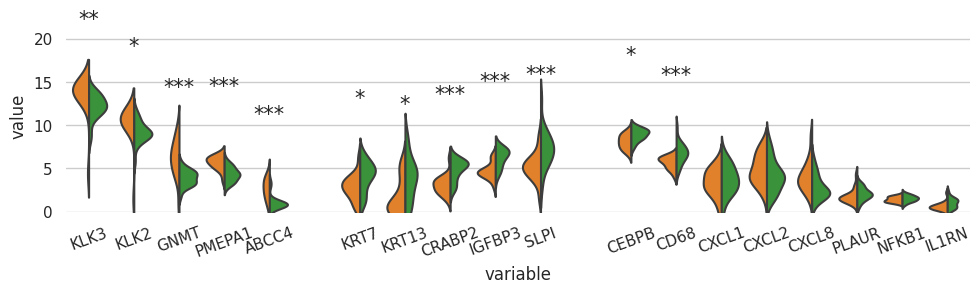

In [165]:
# Violinplot

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))

# Add dividers
plot_df[''] = np.nan
plot_df[' '] = np.nan
plot_df['  '] = np.nan

genes = [
    'KLK3','KLK2','GNMT','PMEPA1','ABCC4','',  #'NKX3-1' # AR
    #'CEACAM1','LCN2','LTF','C3', 'S100A8', 'S100A9','ANXA1',  ' ',  # CD300LD w/ club-region markers 
    'KRT7','KRT13','CRABP2','IGFBP3','SLPI','  ', # EpiSen markers
    'CEBPB','CD68','CXCL1','CXCL2','CXCL8','PLAUR','NFKB1','IL1RN' # NLR-associated
    ]


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(10,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_AR_senescence_NLR_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    ymax = plot_df['value'].max() +2 - (8-vals.mean()) # What a formula :D 
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_AR_senescence_NLR.pdf')
plt.show()

### Plotting violinplot of all club-like senesence genes

In [151]:

# Club senescence genes
n_genes_sen = 15
club_senescence_genes = (list(np.intersect1d(check_top_markers('Club epithelium')['gene'].tolist(), # Club epithelium markers
        gene_set_df['MP19 Epithelial Senescence'].copy().tolist()))) # Senescence markers overlap

de_test_stats = []
for g in club_senescence_genes:
    de_test_stats.append(np.abs(de_res.loc[g,'stat']))

club_senescence_genes = [club_senescence_genes[i] for i in list(np.argsort(de_test_stats)[::-1][:n_genes_sen])] # Keep the top 5 genes with the highest DE test stat
club_senescence_genes


['SLPI',
 'IGFBP3',
 'CRABP2',
 'KRT13',
 'KRT7',
 'MUC4',
 'CXCL17',
 'WFDC2',
 'PI3',
 'MAL2',
 'KRT16',
 'SERPINB1',
 'AGR2',
 'KRT17',
 'CLDN4']

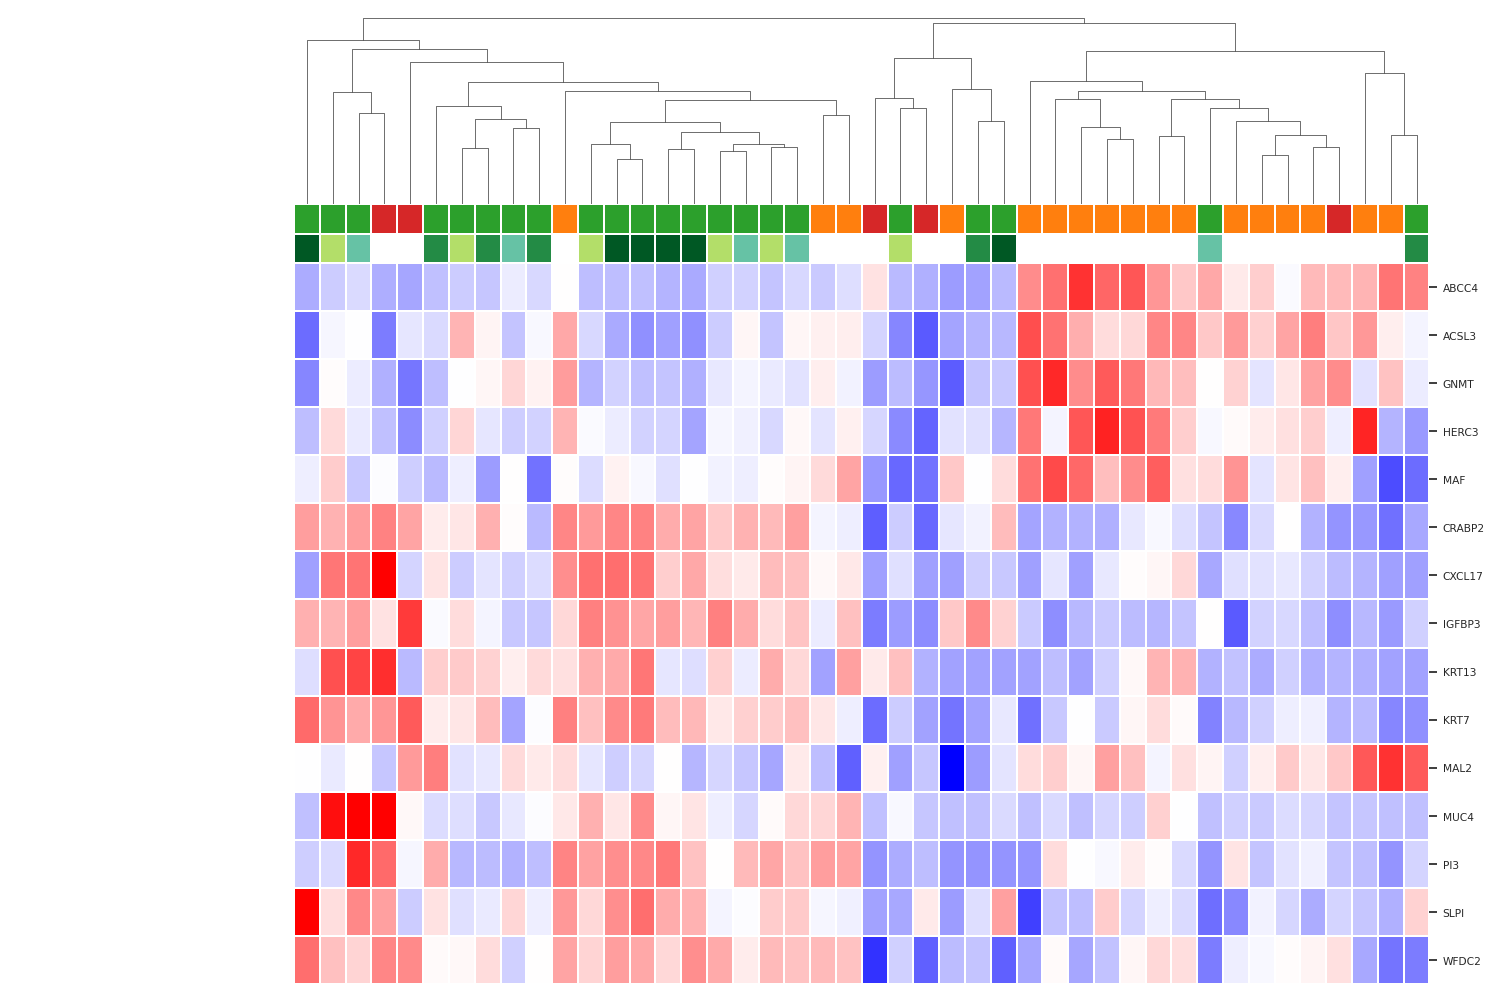

In [142]:
# Heatmap
sns.set_theme(style='white',font_scale=0.7)

# Club-like senescence + AR signaling genes
genes = (gene_set_df['AR signaling'].dropna().copy().tolist() + # All AR signaling genes
        list(np.intersect1d(check_top_markers('Club epithelium')['gene'].tolist(), # Club epithelium markers
        gene_set_df['MP19 Epithelial Senescence'].copy().tolist()))) # Senescence markers overlap

genes = ar_signaling_genes + club_senescence_genes

# Drop genes that are below median baseMean
for g in genes:
    if de_res.loc[g,'baseMean'] < de_res['baseMean'].quantile(0.0):
        genes.remove(g)

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT','CRPC'])].copy()

# Drop the all-stroma TUMOR
#plot_df = plot_df.drop(index='PC_05_13057_OIK_ANT_0')

plot_df = plot_df[genes+['treatment','treatment_detailed']]

col_colors1 = plot_df['treatment'].map({'TRNA':'#ff7f0e','NEADT':'#2ca02c','CRPC':'#d62728'})
col_colors2 = plot_df['treatment_detailed'].map({
    'untreated': '#FFFFFF',
    'crpc': '#FFFFFF',
    'bicalutamide': '#b3de69',  # Light green
    'goserelin': '#66c2a5',  # Medium green
    'degarelix': '#238b45',  # Dark green
    'degarelix_apalutamide': '#005824'  # Darkest green
}

)

#fig, ax = plt.subplots(figsize=(10,6))
h = sns.clustermap(
    plot_df.drop(columns=['treatment','treatment_detailed']).T,
               z_score=0,
               cmap='bwr',
               col_colors=[col_colors1,col_colors2],
               col_cluster=True,
               row_cluster=False,
               linewidth=0.2,
               figsize=(15,10),
               #square=True,
               xticklabels='',
               cbar_pos=None,
               vmin=-3,
               vmax=3
               )


plt.savefig('plots/pseudobulk_log2TPM_heatmap_club_senescence.pdf')
plt.show()

In [99]:
len(genes)

45

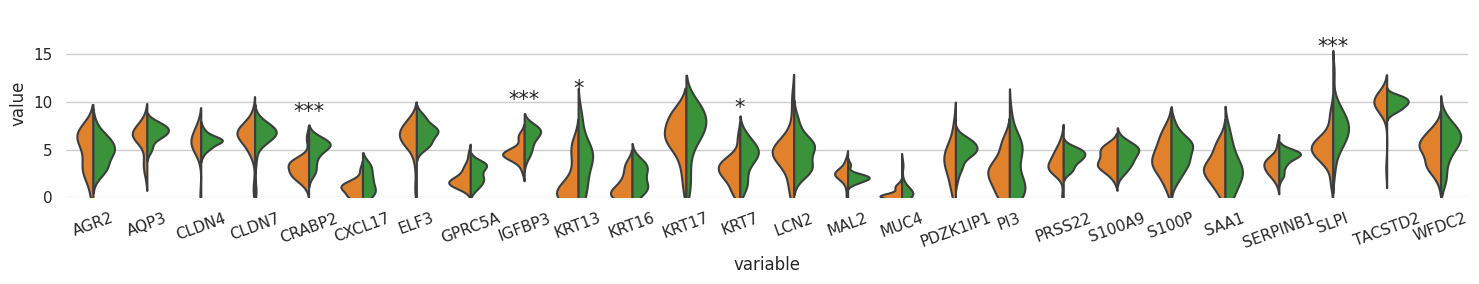

In [62]:
# Violinplot

# Club-like senescence genes
genes = list(np.intersect1d(check_top_markers('Club epithelium')['gene'].tolist(),
                            gene_set_df['MP19 Epithelial Senescence'].copy().tolist()))


plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(15,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_club_senescence_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_club_senescence.pdf')
plt.show()

### Club top 50 genes

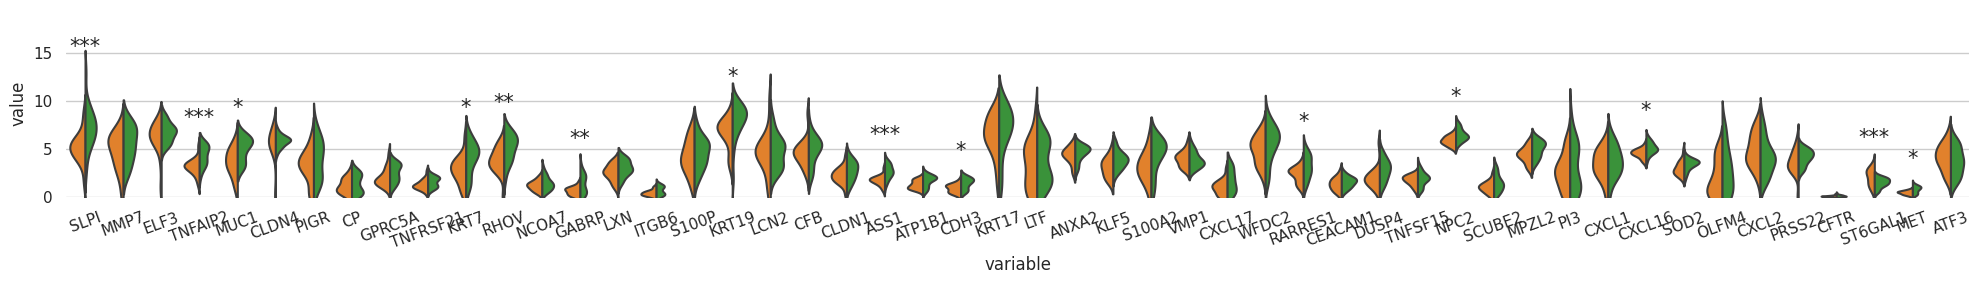

In [66]:
# Violinplot

# Club-like senescence genes
genes = check_top_markers('Club epithelium')['gene'].tolist()[:50]


plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(20,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_club_top50.pdf')
plt.show()

### Senesecence/PMN-MDSC-related genes

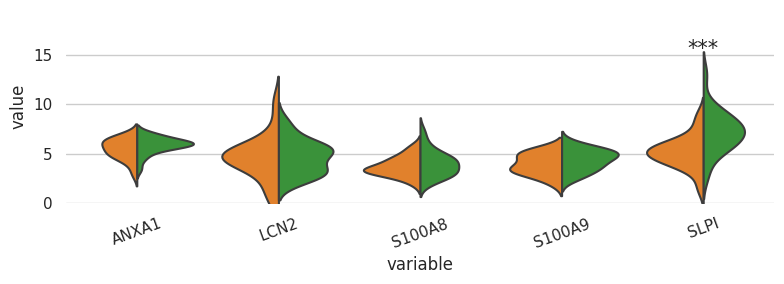

In [68]:
# Violinplot

# Club-like senescence genes
genes = list(np.intersect1d(gene_set_df['CD300LD downstream'].dropna().copy().tolist(),
                            gene_set_df['MP19 Epithelial Senescence'].dropna().copy().tolist()))


plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(8,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_senescence_pmn_mdsc.pdf')
plt.show()

### Plotting violinplot of Il-23 related genes

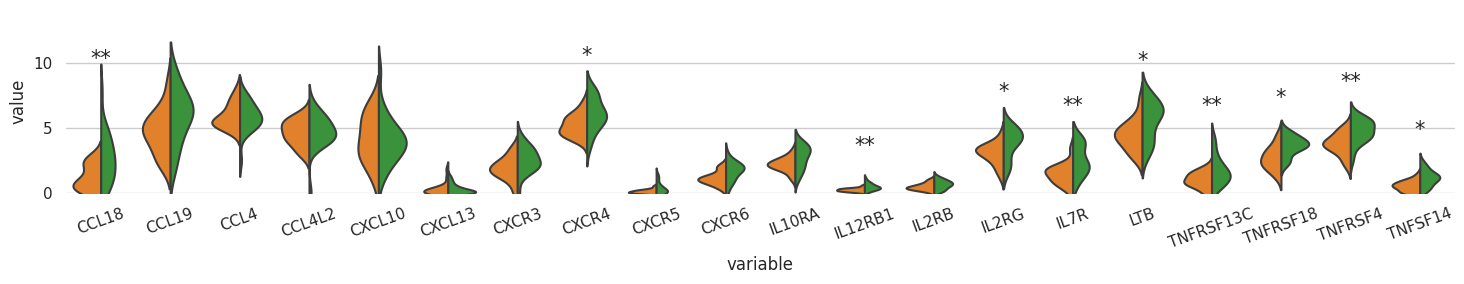

In [20]:
# Immune marker MDSC Calcinotto 2018 overlap
genes = [
    'CCL18', 'CCL19', 'CCL4', 'CCL4L2', 'CXCL10', 'CXCL13', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'IL10RA', 'IL12RB1', 'IL2RB', 'IL2RG', 'IL7R', 'LTB', 'TNFRSF13C', 'TNFRSF18', 'TNFRSF4', 'TNFSF14'
    ]

# Violinplot

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(15,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_MDSC_calcinotto_immune_overlap_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_MDSC_calcinotto_immune_overlap.pdf')
plt.show()

## Plotting custom chemokine list violinplot

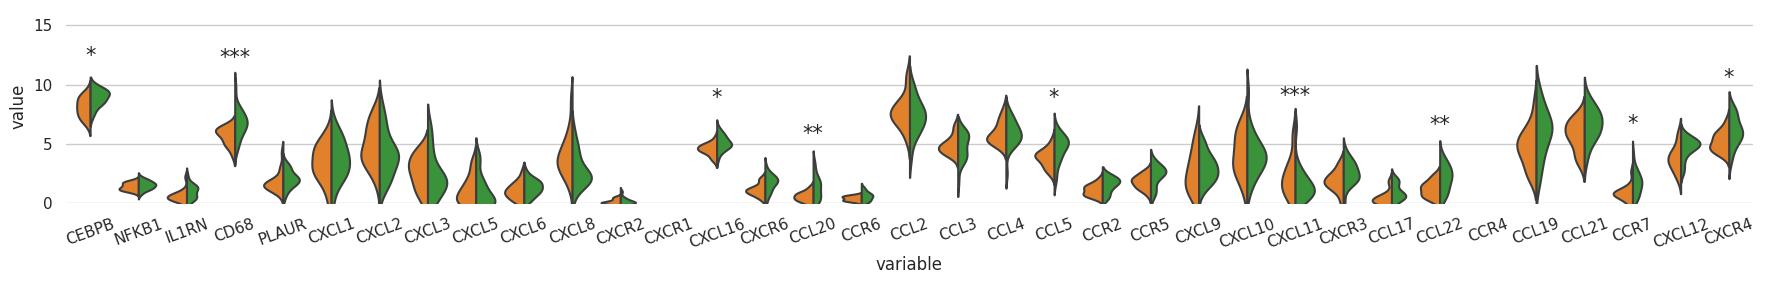

In [21]:
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


genes = [
                    'CEBPB','NFKB1','IL1RN','CD68','PLAUR',
                    'CXCL1','CXCL2','CXCL3','CXCL5','CXCL6','CXCL8','CXCR2','CXCR1',
                    'CXCL16','CXCR6',
                    'CCL20','CCR6',
                    'CCL2','CCL3','CCL4','CCL5','CCR2','CCR5',
                    'CXCL9','CXCL10','CXCL11','CXCR3',
                    'CCL17','CCL22','CCR4',
                    'CCL19','CCL21','CCR7',
                    'CXCL12','CXCR4'
                    ]


# Violinplot

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()

for g in genes:
    if g not in plot_df:
        plot_df[g] = np.nan


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(18,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_chemokines_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_chemokines.pdf')
plt.show()

## Plotting custom chemokine list violinplot

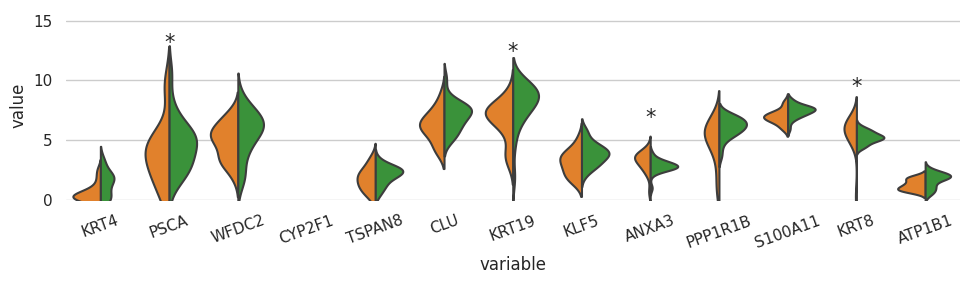

In [22]:
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#ff7f0e','#2ca02c']))


genes = ['KRT4','PSCA','WFDC2','CYP2F1','TSPAN8','CLU','KRT19','KLF5','ANXA3','PPP1R1B','S100A11','KRT8','ATP1B1']


# Violinplot

plot_df = log2_tpm_normalized_dat[log2_tpm_normalized_dat['treatment'].isin(['TRNA','NEADT'])].copy()

for g in genes:
    if g not in plot_df:
        plot_df[g] = np.nan


plot_df = plot_df[genes + ['treatment']].reset_index().melt(['index','treatment'])

fig, ax = plt.subplots(figsize=(10,3))
sns.violinplot(plot_df,x='variable',y='value',hue='treatment',split=True,inner=None)

ax.set_ylim(0,plot_df['value'].max() + plot_df['value'].max()/2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_legend().remove()
plt.tight_layout()

plt.savefig('plots/pseudobulk_violin_progenitor_signature_no_asterisks.pdf')

# Set significance markers and place them at the correct location

marker_lst = []
for g in genes:

    try: 
        padj = de_res.loc[g,'padj']
        if padj < 0.001:
            marker_lst.append('***')
        elif padj < 0.01:
            marker_lst.append('**')
        elif padj < 0.05:
            marker_lst.append('*')
        else:
            marker_lst.append('')
    except:
        marker_lst.append('')

for i,g in enumerate(genes):
    vals = plot_df[plot_df['variable']==g]['value']
    #ymax = vals.max() + vals.mean()/3
    #ymax = plot_df['value'].max() +2
    ymax = vals.max() +2
    ax.text(x=i,y=ymax,s=marker_lst[i],ha='center',fontdict={'size':15})

plt.savefig('plots/pseudobulk_violin_progenitor_signature.pdf')
plt.show()

## Pseudobulk gene set activity scoring

### Loading the gene modules

In [41]:
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

gene_modules_dict = {
    'Tumor region': check_top_markers('Tumor')['gene'].tolist(),
    'Luminal region': check_top_markers('Luminal epithelium')['gene'].tolist(),
    'Basal region': check_top_markers('Basal epithelium')['gene'].tolist(),
    'Club region': check_top_markers('Club epithelium')['gene'].tolist(),
    'Immune region': check_top_markers('Immune')['gene'].tolist()
                    }

gene_modules_dict = {**gene_modules_dict,**gene_set_df.to_dict(orient='list')}
gene_modules_dict['Club_prosgenesis'] = list(np.intersect1d(gene_modules_dict['PROSGenesis'],gene_modules_dict['Club region']))
gene_modules_dict['Club_SCL'] = list(np.intersect1d(gene_modules_dict['CRPC-SCL'],gene_modules_dict['Club region']))
gene_modules_dict['Club_region_excl_club'] = list(set(gene_modules_dict['Club region']) - set(gene_modules_dict['Club']))
gene_modules_dict['Club_senescence_overlap'] = list(set(gene_modules_dict['Club region']).intersection(set(gene_modules_dict['MP19 Epithelial Senescence'])))
gene_modules_dict['MDSC_calcinotto_immmune_overlap'] = list(set(gene_modules_dict['Immune region']).intersection(set(gene_modules_dict['MDSC Calcinotto 2018'])))

treat_colors = {
    'BPH':'#1f77b4',
    'TRNA':'#ff7f0e',
    'NEADT':'#2ca02c',
    'CRPC':'#d62728'
}

treat_classes = list(treat_colors.keys())

sns.set_palette(sns.color_palette(treat_colors.values()))


In [38]:
pseudobulk_dat_log2_tpm = log2_tpm_normalized_dat.drop(columns=['treatment','treatment_detailed']).T


# Score all the gene sets with GSVA
gsva_res = gp.gsva(data=pseudobulk_dat_log2_tpm,gene_sets=gene_modules_dict,outdir=None,min_size=0,max_size=5000)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Add a sample class identifier column
gsva_res_df['sample_class'] = gsva_res_df['Sample Identifier'].map(treat_info).map(treatment_mapping_dict_simple).astype('category').cat.set_categories(treat_classes)



In [39]:
# Keep only the TRNA & NEADT 
gsva_res_df_trt = gsva_res_df[gsva_res_df['sample_class'].isin(['TRNA','NEADT'])].copy()
gsva_res_df_trt['sample_class'] = gsva_res_df_trt['sample_class'].astype('category').cat.set_categories(['TRNA','NEADT']).copy()

sns.set_palette(sns.color_palette([treat_colors['TRNA'],treat_colors['NEADT']]))

In [ ]:
for gene_set in ['Club_senescence_overlap','NLR associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']:

    df = gsva_res_df_trt.reset_index(drop=True).copy()
    df['foo'] = 'bar'

    df[gene_set] = df[gene_set].astype(float)

    values = df[gene_set]
    categories = df['sample_class']

    statistic, p_value = mannwhitneyu(*[values[categories == cat] for cat in ['NEADT','TRNA']])

    print(gene_set + ' p-value: {:.2e}'.format(p_value))

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

    ax.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    # create scatterplot with color-coded points

    sns.violinplot(df,x = 'foo',y = gene_set, hue='sample_class',split=True,ax = ax,inner=None)

    ymin = df[gene_set].min()-0.5
    ymax = df[gene_set].max()+0.5
    ax.set(ylim=(ymin, ymax))
    plt.title('U-test pval:{:.2e}'.format(p_value))
    plt.legend().remove()


    plt.tight_layout()
    plt.savefig('plots/score_violins/pseudobulk/'+gene_set.replace(' ', '_').replace('/','_')+'_treatment_effect_violin.pdf')
    plt.show()
    #plt.clf()



In [ ]:
#for gene_set in ['Club_senescence_overlap','NLR associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']:
for gene_set in gene_modules_dict.keys():

    df = gsva_res_df_trt.reset_index(drop=True).copy()
    df['foo'] = 'bar'

    df[gene_set] = df[gene_set].astype(float)

    values = df[gene_set]
    categories = df['sample_class']

    statistic, p_value = mannwhitneyu(*[values[categories == cat] for cat in ['NEADT','TRNA']])

    if p_value < 0.05:
        print(gene_set + ' p-value: {:.2e}'.format(p_value))

        ## PLOT ##
        fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

        ax.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
        plt.yticks(np.arange(-1,2,0.2).astype(float))

        # create scatterplot with color-coded points

        sns.violinplot(df,x = 'foo',y = gene_set, hue='sample_class',split=True,ax = ax,inner=None)

        ymin = df[gene_set].min()-0.5
        ymax = df[gene_set].max()+0.5
        ax.set(ylim=(ymin, ymax))
        plt.title('U-test pval:{:.2e}'.format(p_value))
        plt.legend().remove()

        plt.tight_layout()

        plt.savefig('plots/score_violins/pseudobulk/'+gene_set.replace(' ', '_').replace('/','_')+'_treatment_effect_violin.pdf')
        plt.show()
        #plt.clf()



In [ ]:
gsva_res_df_trt.groupby('sample_class')[gene_set].all()

### 

### Plot score correlations without overlap

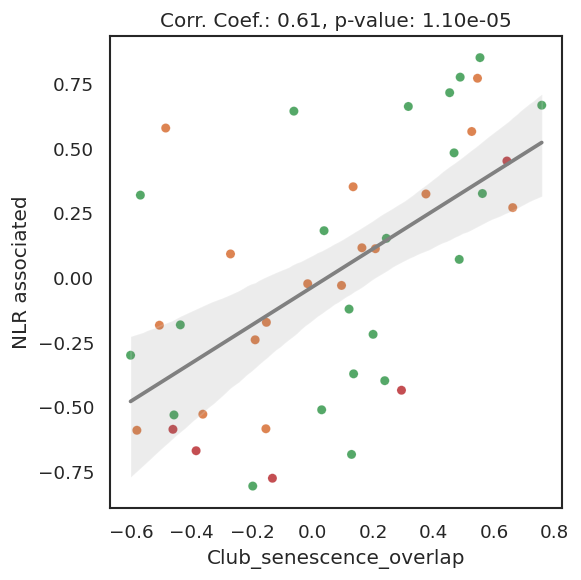

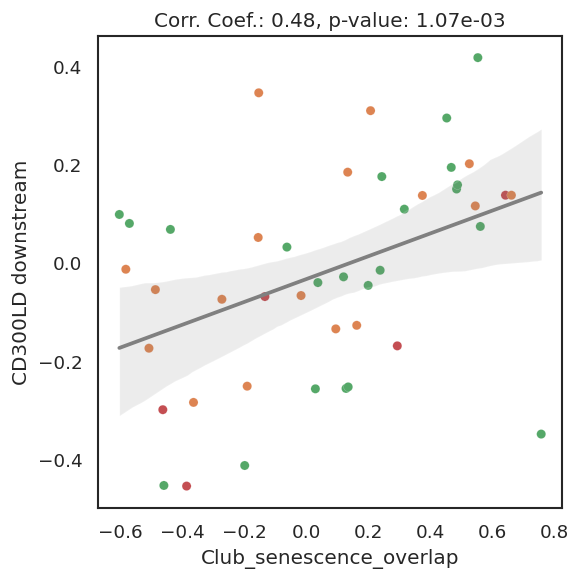

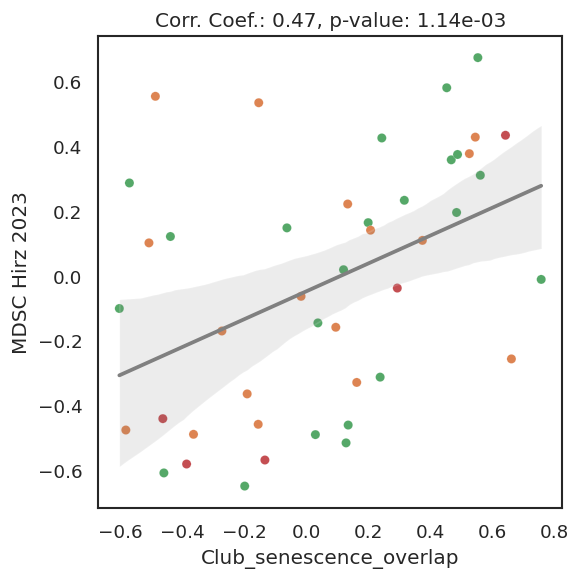

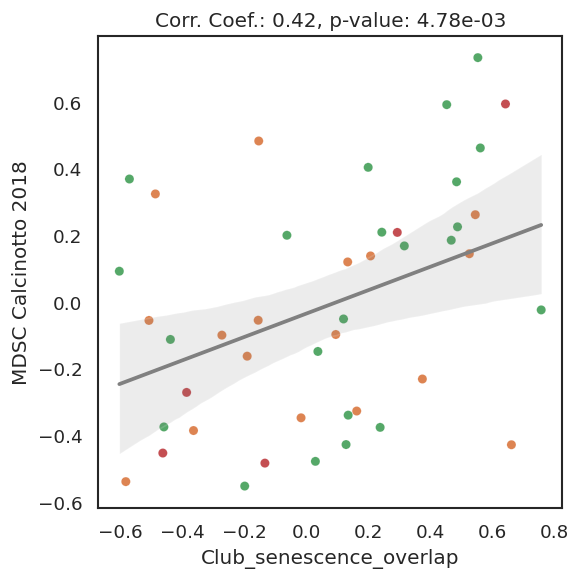

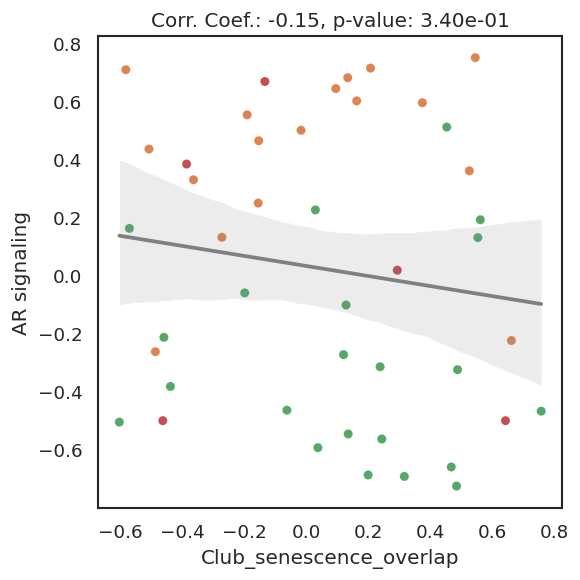

In [43]:
sns.set_theme(style='white')
# Signature-specific scoring is required, as overlaps need to be taken into account

signature1 = 'Club_senescence_overlap'#'Club region'#'MP19 Epithelial Senescence'
signature2s = ['NLR associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']


simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}

for signature2 in signature2s:

    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set



pseudobulk_dat_log2_tpm = log2_tpm_normalized_dat.drop(columns=['treatment','treatment_detailed']).T


gsva_res = gp.gsva(data=pseudobulk_dat_log2_tpm,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Add a sample class identifier column
gsva_res_df['sample_class'] = gsva_res_df['Sample Identifier'].map(treat_info).map(treatment_mapping_dict_simple).astype('category').cat.set_categories(['BPH','TRNA','NEADT','CRPC'])

gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

gsva_res_df = gsva_res_df[gsva_res_df['sample_class'].isin(['TRNA','NEADT','CRPC'])] # 'BPH','TRNA','NEADT','CRPC'

for signature2 in signature2s:

    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, hue='sample_class', linewidth=0.1, s=30, ax=ax,legend=False) # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    #ax.set_ylim(-0.5,1.0)
    #ax.set_xlim(0,1.2)
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    plt.savefig('plots/score_correlations/'+signature1.replace(' ','_')+'_'+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')
    #plt.savefig('plots/score_correlations/'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk.pdf')
    plt.show()
    #plt.clf()

## DESeq2 testing

In [44]:
import anndata as ad
from pydeseq2 import dds
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

In [7]:
# Transpose the data
pseudobulk_dat_T = pseudobulk_dat.T

# Add the treatment information
pseudobulk_dat_T['treatment'] = pseudobulk_dat_T.index.map(treat_info).map(treatment_mapping_dict_simple).tolist()

# Filter to contain only the treatnment-naive and the ADT treated
pseudobulk_dat_T =  pseudobulk_dat_T[pseudobulk_dat_T['treatment'].isin(['TRNA','NEADT'])]


In [8]:
# Construct the DESeq2 dataset
pseudobulk_as_adata = ad.AnnData(pseudobulk_dat_T.drop(columns=['treatment']),
           var=pd.DataFrame(index=pseudobulk_dat_T.drop(columns=['treatment']).columns),
           obs=pseudobulk_dat_T[['treatment']]
           )

deseq_dataset = dds.DeseqDataSet(adata=pseudobulk_as_adata,design_factors='treatment', ref_level=['treatment','TRNA'])

# Run the DESeq2 analysis
deseq_dataset.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 14.55 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 14.90 seconds.

Fitting LFCs...
... done in 2.35 seconds.

Refitting 972 outliers.

Fitting dispersions...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 0.55 seconds.

Fitting LFCs...
... done in 0.23 seconds.



In [9]:
# Define the inference
inference = DefaultInference(n_cpus=2)

# Calculate the test statistics, lfc and p-values
stat_res = DeseqStats(deseq_dataset, inference=inference)
stat_res.summary()

# Get the final dataframe
de_res = stat_res.results_df.copy()

# Save the results into a csv file for later use
de_res.to_csv('./data/pseudobulk_deseq_res_trna_vs_neadt.csv')

Running Wald tests...
... done in 6.79 seconds.



Log2 fold change & Wald test p-value: treatment NEADT vs TRNA
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        421.275726        0.767528  0.327602  2.342865  0.019136  0.058806
A1BG-AS1     53.164989        0.829052  0.319680  2.593381  0.009504  0.034466
A1CF          0.285621        0.893868  3.081769  0.290050  0.771778       NaN
A2M       15241.339844        0.436836  0.300557  1.453419  0.146107  0.274791
A2M-AS1      51.585648        0.677634  0.198633  3.411488  0.000646  0.004178
...                ...             ...       ...       ...       ...       ...
ZXDC        308.620392        0.348826  0.150626  2.315842  0.020567  0.062229
ZYG11A       49.847469        0.226922  0.358821  0.632409  0.527120  0.672008
ZYG11B      546.892944       -0.125416  0.105577 -1.187906  0.234871  0.386940
ZYX        2827.512939        0.452416  0.208853  2.166195  0.030296  0.083276
ZZEF1       434.725708        0.108729  0.075083  1.448114  0.147585 

In [10]:
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/pseudobulk_deseq2_results_trna_vs_neadt.xlsx', engine='xlsxwriter')

# Write the dataframe into a  Excel file
de_res.reset_index(names='gene').to_excel(writer)

# Save and close the Excel writer
writer.save()